# Document Retrieve - Chunking (Manual)

Chunking document manually using LangChain

- Chunking
    - md & text split of md formated texet
- Data analysis (Token size)

## Doucment prep

Azure OpenAI documents (MD formatted)
- https://github.com/MicrosoftDocs/azure-docs/tree/main/articles/ai-services/openai

In [1]:
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")

def token_size(text):
    return len(encoding.encode(text))

In [2]:
import os
import pandas as pd
import re

In [3]:
def remove_between_markers(text, start_marker, end_marker):
    # Find the start and end positions of the markers
    start_pos = text.find(start_marker)
    end_pos = text.find(end_marker, start_pos + len(start_marker))
    
    # Remove the content between the markers
    if start_pos != -1 and end_pos != -1:
        return text[:start_pos] + text[end_pos + len(end_marker):]
    else:
        return text

In [4]:
# Create an empty DataFrame with specific column names
df = pd.DataFrame(columns=['file_name', 'size', 'token_size', 'title', 'content'])

for md in os.listdir("./docs"):
    if not os.path.isdir(md):
        with open(f'./docs/{md}', "r") as f:
            text = f.read()

    pattern = r"title:\s*(.*)"
    matches = re.search(pattern, text)

    # get title from header
    title = ""
    if matches:
        title = matches.group(1)
        title = title.replace("'", "")
    else:
        title = md

    # clean header
    text = remove_between_markers(text, "---", "---\n\n")
    
    new_row = {'file_name': md, 'size': len(text), 'token_size': token_size(text), 'title':  title, 'content': text}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

df

,file_name,size,token_size,title,content
0,fine-tuning-python.md,33086,7734,Customize a model with Azure OpenAI Service an...,## Prerequisites\n\n- Read the [When to use Az...
1,chatgpt.md,2138,474,How to work with the GPT-35-Turbo and GPT-4 mo...,# Learn how to work with the GPT-35-Turbo and ...
2,prompt-completion.md,24070,5541,How to work with prompt engineering and the Co...,> [!NOTE]\n> All of the examples in this secti...
3,chat-markup-language.md,13931,3419,How to work with the Chat Markup Language (pre...,## Working with the Chat models\n\n> [!IMPORTA...
4,assistants-studio.md,7851,1738,Quickstart: Use Azure OpenAI Assistants (Previ...,## Prerequisites\n\n- An Azure subscription - ...
...,...,...,...,...,...
133,assistants-quickstart.md,618,139,Quickstart - Getting started with Azure OpenAI...,\n# Quickstart: Get started using Azure OpenAI...
134,chatgpt-quickstart.md,1202,310,Quickstart - Get started using GPT-35-Turbo an...,# Quickstart: Get started using GPT-35-Turbo a...
135,dynamic-quota.md,4584,925,Azure OpenAI Service dynamic quota,\n# Azure OpenAI Dynamic quota (Preview)\n\nDy...
136,assistant.md,32303,8656,How to create Assistants with Azure OpenAI Ser...,# Getting started with Azure OpenAI Assistants...


## Chunking Comparison

- https://github.com/Azure/azure-search-vector-samples/blob/main/demo-python/code/data-chunking/langchain-data-chunking-example.ipynb
- https://python.langchain.com/docs/modules/data_connection/document_loaders/file_directory#auto-detect-file-encodings-with-textloader

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter

def get_encoding_name(model="gpt-3.5-turbo"):
    return tiktoken.encoding_for_model(model).name

In [6]:
# test chunking
#row = df[df['file_name'] == 'use-your-data.md']
row = df[df['file_name'] == 'assistant.md']
# use list function to show all text in the cell
md_content = list(row['content'])[0]
md_content

'# Getting started with Azure OpenAI Assistants (Preview)\n\nAzure OpenAI Assistants (Preview) allows you to create AI assistants tailored to your needs through custom instructions and augmented by advanced tools like code interpreter, and custom functions. In this article we\'ll provide an in-depth walkthrough of getting started with the Assistants API.\n\n## Assistants support\n\n### Region and model support\n\nThe [models page](../concepts/models.md#assistants-preview) contains the most up-to-date information on regions/models where Assistants are currently supported.\n\n### API Version\n\n- `2024-02-15-preview`\n\n### Supported file types\n\n|File format|MIME Type|Code Interpreter |\n|---|---|---|\n|.c| text/x-c |✅|\n|.cpp|text/x-c++ |✅|\n|.csv|application/csv|✅|\n|.docx|application/vnd.openxmlformats-officedocument.wordprocessingml.document|✅|\n|.html|text/html|✅|\n|.java|text/x-java|✅|\n|.json|application/json|✅|\n|.md|text/markdown| ✅ |\n|.pdf|application/pdf|✅|\n|.php|text/x-ph

In [7]:
headers_to_split_on = [
    ("#", "H1"),
    ("##", "H2"),
]

markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
md_header_splits = markdown_splitter.split_text(md_content)
len(md_header_splits)

8

In [8]:
for j, md_split in enumerate(md_header_splits):
    if 'H1' in md_split.metadata:
        if 'H2' in md_split.metadata:
            chunk = f"## {md_split.metadata['H2']}\n{md_split.page_content}"
        else:
            chunk = f"# {md_split.metadata['H1']}\n{md_split.page_content}"
    else:
        chunk = md_split.page_content
    print(j, token_size(chunk))

0 65
1 476
2 43
3 215
4 6348
5 377
6 516
7 69


In [9]:
# Char-level splits
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name=get_encoding_name(),
    chunk_size=1200, 
    chunk_overlap=125
)

# Split
splits = text_splitter.split_documents(md_header_splits)
len(splits)

16

In [10]:
for j, md_split in enumerate(splits):
    if 'H1' in md_split.metadata:
        if 'H2' in md_split.metadata:
            chunk = f"## {md_split.metadata['H2']}\n{md_split.page_content}"
        else:
            chunk = f"# {md_split.metadata['H1']}\n{md_split.page_content}"
    else:
        chunk = md_split.page_content
    print(j, token_size(chunk))

0 65
1 476
2 43
3 215
4 312
5 1183
6 1167
7 411
8 1189
9 280
10 1084
11 928
12 109
13 377
14 516
15 69


## MD Chunking

In [11]:
markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
md_header_splits = markdown_splitter.split_text(md_content)
len(md_header_splits)

chunked_data = pd.DataFrame(columns=['title', 'chunk', 'parent_id', 'chunk_id', 'token_size'])

for i in range(len(df)):
    row = df.iloc[i]

    md_content = row['content']
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    md_header_splits = markdown_splitter.split_text(md_content)

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        encoding_name=get_encoding_name(),
        chunk_size=1000, 
        chunk_overlap=125
    )

    # Split
    splits = text_splitter.split_documents(md_header_splits)

    for j, md_split in enumerate(splits):
        try:
            if 'H1' in md_split.metadata:
                if 'H2' in md_split.metadata:
                    chunk = f"## {md_split.metadata['H2']}\n{md_split.page_content}"
                else:
                    chunk = f"# {md_split.metadata['H1']}\n{md_split.page_content}"
            else:
                chunk = md_split.page_content
            new_row = {'title':  row['title'], 'chunk': chunk, 'parent_id': row['file_name'], 'chunk_id': j, 'token_size': token_size(chunk)}
            chunked_data = pd.concat([chunked_data, pd.DataFrame([new_row])], ignore_index=True)
        
        except Exception as e:
            print(f"Error: {i}, {j}, {e}\n{md_split.metadata}")


chunked_data

,title,chunk,parent_id,chunk_id,token_size
0,Customize a model with Azure OpenAI Service an...,- Read the [When to use Azure OpenAI fine-tuni...,fine-tuning-python.md,0,232
1,Customize a model with Azure OpenAI Service an...,The following models support fine-tuning: \n-...,fine-tuning-python.md,1,79
2,Customize a model with Azure OpenAI Service an...,Take a moment to review the fine-tuning workfl...,fine-tuning-python.md,2,135
3,Customize a model with Azure OpenAI Service an...,# [chat completion models](#tab/turbo)\nThe tr...,fine-tuning-python.md,3,743
4,Customize a model with Azure OpenAI Service an...,# [babbage-002/davinci-002](#tab/completionfin...,fine-tuning-python.md,4,745
...,...,...,...,...,...
1112,Quickstart: Use the OpenAI Service to make you...,### Retrieve key and endpoint \nTo successful...,rest.md,1,453
1113,Quickstart: Use the OpenAI Service to make you...,"In a bash shell, run the following command. Yo...",rest.md,2,329
1114,Quickstart: Use the OpenAI Service to make you...,The output from the completions API will look ...,rest.md,3,256
1115,Quickstart: Use the OpenAI Service to make you...,If you want to clean up and remove an OpenAI r...,rest.md,4,77


In [12]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra

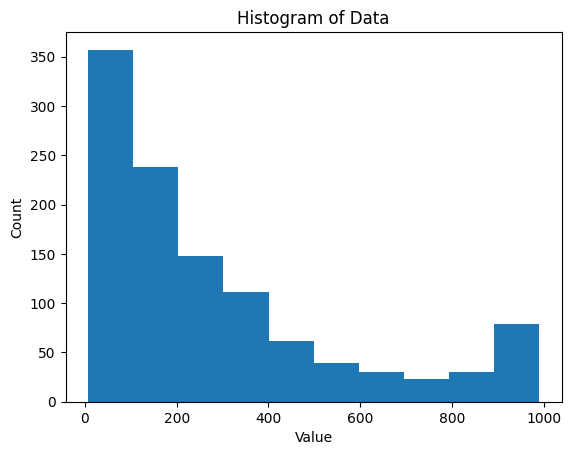

In [13]:
# chatgpt promt: "python code to plot a graph group by count of bin size from data"
data = chunked_data['token_size']

bin_size = 100

# Calculate the number of bins based on the bin size
num_bins = int(np.ceil((data.max() - data.min()) / bin_size))

# Create the histogram
plt.hist(data, bins=num_bins)

# Set the axis labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram of Data')

# Show the plot
plt.show()

In [14]:
# file with token size > 2K
len(chunked_data[chunked_data['token_size'] > 2000])

0

In [ ]:
# save to file
#chunked_data.to_pickle('./aoai-docs_md.pkl')